# CONFIGURATION:

In [ ]:
from jaad_data import JAAD
import torch
from PIL import Image
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
import network
import openpose
from openpose import model
from openpose import util
from openpose.body import Body
import copy
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchmetrics
from torcheval.metrics import BinaryAccuracy
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score



In [ ]:
JAAD_PATH = '../JAAD'
DEEPLAB_PATH = '../best_deeplabv3plus_resnet101_cityscapes_os16.pth'
SUBSET_PATH = '../subset2'
#SUBSET_BALANCED ='../subset2'

RESULTS_MASK_SUB = '../masks_results_sub.pkl'
RESULTS_MASK_BIG = '../masks_results_big.pkl'
RESULTS_MASK_BIG_TEST = '../masks_results_big_test.pkl'
RESULTS_MASK_SUB_TEST = '../masks_results_sub_test.pkl'

RESULTS_POSE_BIG = '../pose_results_big.pkl'
RESULTS_POSE_SUB = '../pose_results_sub.pkl'
RESULTS_POSE_BIG_TEST = '../pose_results_big_test.pkl'
RESULTS_POSE_SUB_TEST = '../pose_results_sub_test.pkl'

POSE_PATH = '../body_pose_model.pth'   


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.cuda.empty_cache()


cuda


In [ ]:
# CONFIG: 
RUN = False
BIG =False

In [ ]:
if BIG:
    MASK_CMD = RESULTS_MASK_BIG
    POSE_CMD = RESULTS_POSE_BIG
    MASK_CMD_TEST = RESULTS_MASK_BIG_TEST
    POSE_CMD_TEST = RESULTS_POSE_BIG_TEST
    DT_CMD = JAAD_PATH
else:
    MASK_CMD = RESULTS_MASK_SUB
    POSE_CMD = RESULTS_POSE_SUB
    MASK_CMD_TEST = RESULTS_MASK_SUB_TEST
    POSE_CMD_TEST = RESULTS_POSE_SUB_TEST
    DT_CMD = SUBSET_PATH



# DATASET

In [ ]:
# stampa una sequenza di informazioni del dataset

#jaad_dt.generate_database() # in particolare, questo stampa un sacco di informazioni come borse vestiti semafori ecc
#jaad_dt.get_data_stats() # mentre questo stampa informazioni sui numeri di frame, video, pedoni, bbox ecc
#print('Train sequences:', len(seq_train['image'][0][0]))  # stampa la lunghezza della sequenza di training selezionata

In [44]:
# Load the JAAD dataset
jaad_dt = JAAD(data_path='../subset2')

data_opts = {
    'fstride': 15,
    #'subset': 'high_visibility',
    'sample_type': 'all'
}

seq_train = jaad_dt.generate_data_trajectory_sequence('train', **data_opts)  
seq_test = jaad_dt.generate_data_trajectory_sequence('test', **data_opts)  

---------------------------------------------------------
Generating action sequence data
fstride: 15
sample_type: all
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000195A71BE790>>
Traceback (most recent call last):
  File "C:\Users\jacop\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


jaad database loaded from c:\Users\jacop\Documents\ComputerVision\subset2\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 185 
Total number of samples: 60 
---------------------------------------------------------
Generating action sequence data
fstride: 15
sample_type: all
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from c:\Users\jacop\Documents\ComputerVision\subset2\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: test
Number of pedestrians: 251 
Total number of samples: 97 


In [ ]:
print((seq_train['image']))
print((seq_test['image'][1]))
# print(len(seq_train['bbox']))

[['../subset2\\images\\video_0001\\00000.png', '../subset2\\images\\video_0001\\00015.png', '../subset2\\images\\video_0001\\00030.png', '../subset2\\images\\video_0001\\00045.png', '../subset2\\images\\video_0001\\00060.png', '../subset2\\images\\video_0001\\00075.png', '../subset2\\images\\video_0001\\00090.png', '../subset2\\images\\video_0001\\00105.png', '../subset2\\images\\video_0001\\00120.png', '../subset2\\images\\video_0001\\00135.png', '../subset2\\images\\video_0001\\00150.png', '../subset2\\images\\video_0001\\00165.png', '../subset2\\images\\video_0001\\00180.png', '../subset2\\images\\video_0001\\00195.png', '../subset2\\images\\video_0001\\00210.png', '../subset2\\images\\video_0001\\00225.png', '../subset2\\images\\video_0001\\00240.png', '../subset2\\images\\video_0001\\00255.png', '../subset2\\images\\video_0001\\00270.png', '../subset2\\images\\video_0001\\00285.png', '../subset2\\images\\video_0001\\00300.png', '../subset2\\images\\video_0001\\00315.png', '../subs

In [ ]:
# Trasformazioni per le immaginin che vengono usate nel local context e nel pose extractor
transform_lc = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GLOBAL CONTEXT EXTRACTION:

In [ ]:
if RUN:
    deeplab_model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=19)
    deeplab_model.load_state_dict(torch.load(DEEPLAB_PATH)['model_state'])
    deeplab_model.to(device)
    deeplab_model.eval()

In [ ]:
#trasformazioni che vengono usate dentro global context (modifica l'input prima che vada in deeplab)

train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Ridimensiona le immagini a 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#processa output deeplab
GC_trans = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini a 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def get_segmentation_mask(image_path, model, preprocess):
    """ funzione che prende in input le path delle imagini, il modello e la funzione di preprocessamento 
    e restituisce la maschera segmentata dell'immagine resizata a 224x224"""
    
    # Load the image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)  # Create a batch with a single image
    
    # Pass the image through the model
    with torch.no_grad():
        output = model(input_batch)
        
    # Check if output is a tensor or a dictionary
    if isinstance(output, dict):
        output = output['out'][0]
    elif isinstance(output, torch.Tensor):
        output = output[0]
    else:
        raise ValueError(f"Unexpected output type: {type(output)}")
    
    # Convert the output to a mask
    output_predictions = output.argmax(0)
    
    # Aggiungi una dimensione batch e canale alla maschera per il ridimensionamento
    output_predictions = output_predictions.unsqueeze(0).unsqueeze(0).float()
    #print(output_predictions.shape)
    tr = transforms.ToPILImage()
    pic = tr(output_predictions.squeeze(1))
    pic= pic.convert("RGB")
    resized_mask = GC_trans(pic)
    #print(resized_mask.shape)
    # resized_maskk = tr(resized_mask)
    # plt.imshow(resized_maskk)
    # plt.show()
    return resized_mask

In [ ]:
def process_video_frames(seq_train, model, preprocess):
    """funzione che prende in input la sequenza di training, il modello e la funzione di preprocessamento, restituisce una
    lista di segmentation mask per ogni frame di ogni video della sequenza di training"""
    
    all_masks = []
    for video_frames in tqdm(seq_train['image'], desc="Processing videos"):
        video_masks = []

        for frame_path in tqdm(video_frames, desc="Processing frames", leave=False):
            mask = get_segmentation_mask(frame_path, model, preprocess)
            #visualize_mask(frame_path, mask)
            video_masks.append(mask)
        all_masks.append(video_masks)
    
    return all_masks


In [ ]:
# Visualizza la maschera semantica
def visualize_mask(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))  # Ridimensiona per la visualizzazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet')
    plt.title("Semantic Mask")
    plt.show()


In [ ]:
if RUN:
    all_video_masks = process_video_frames(seq_train, deeplab_model, train_transforms)
    seq_train['masks'] = all_video_masks
    all_video_masks_test = process_video_frames(seq_test, deeplab_model, train_transforms)
    seq_test['masks'] = all_video_masks_test
    del deeplab_model
    torch.cuda.empty_cache()
    # Apri il file in modalità scrittura binaria e salva il dizionario
    with open(MASK_CMD, 'wb') as f:
        pickle.dump(seq_train['masks'], f)
    with open(MASK_CMD_TEST, 'wb') as f:
        pickle.dump(seq_test['masks'], f)
else:
    #recover data:
    with open(MASK_CMD, 'rb') as f:
        seq_train['masks'] = pickle.load(f)
    with open(MASK_CMD_TEST, 'rb') as f:
        seq_test['masks'] = pickle.load(f)
    # Verifica che i risultati siano stati caricati correttamente
    #print(seq_train['masks'])

# LOCAL CONTEXT:

In [ ]:
def crop_image_cv2(img, bbox):
    """ funzione che croppa i frames sul bounding boxes, le imagini sono in formato cv2"""
    
    x1, y1, x2, y2 = bbox
    return img[int(y1):int(y2), int(x1):int(x2)]

In [ ]:
"""Trasformation for the local context's images, enhance the quality of the images by appling gaussian filter, unsharp mask e bilateral filter"""
all_images = []
for i in tqdm(range(len(seq_train['image'])), desc="Processing videos"):
    aux_list = []
    for j in tqdm(range(len(seq_train['image'][i])), desc="Processing frames", leave=False):
        
        # Open the images from the paths
        img_path = seq_train['image'][i][j]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        bbox = seq_train['bbox'][i][j]
        # Compute local context cropping images around the bboxes
        cropped_images = crop_image_cv2(img, bbox)
        
        # Enhance the image using various filters
        # blurred_image = cv2.GaussianBlur(cropped_images, (5, 5), 0)

        # sharpness = 1.5  # Sharpness factor
        # blurred_for_sharp = cv2.GaussianBlur(blurred_image, (0, 0), 5)
        # sharpened_image = cv2.addWeighted(blurred_image, 1.0 + sharpness, blurred_for_sharp, -sharpness, 0)

        # # Noise reduction using bilateral filter
        #denoised_image = cv2.bilateralFilter(cropped_images, 9, 75, 75)
        final_image = cv2.resize(cropped_images, (224, 224))
        aux_list.append(final_image)
    all_images.append(aux_list)

# print(type(all_images))
# print(all_images[0][0])
# plt.figure(figsize=(8, 8))
# plt.imshow(all_images[0][0])
# plt.axis('off')
# plt.title("Original (Denormalized) Image")
# plt.show()

Processing videos: 100%|██████████| 60/60 [00:27<00:00,  2.19it/s]


(224, 224, 3)


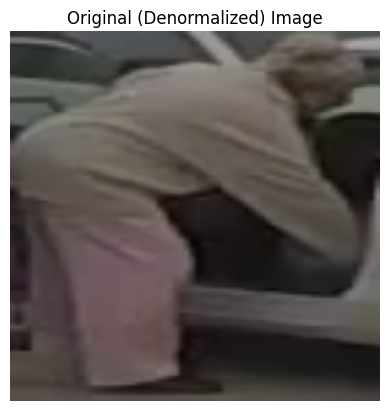

['../subset2\\images\\video_0001\\00000.png', '../subset2\\images\\video_0001\\00015.png', '../subset2\\images\\video_0001\\00030.png', '../subset2\\images\\video_0001\\00045.png', '../subset2\\images\\video_0001\\00060.png', '../subset2\\images\\video_0001\\00075.png', '../subset2\\images\\video_0001\\00090.png', '../subset2\\images\\video_0001\\00105.png', '../subset2\\images\\video_0001\\00120.png', '../subset2\\images\\video_0001\\00135.png', '../subset2\\images\\video_0001\\00150.png', '../subset2\\images\\video_0001\\00165.png', '../subset2\\images\\video_0001\\00180.png', '../subset2\\images\\video_0001\\00195.png', '../subset2\\images\\video_0001\\00210.png', '../subset2\\images\\video_0001\\00225.png', '../subset2\\images\\video_0001\\00240.png', '../subset2\\images\\video_0001\\00255.png', '../subset2\\images\\video_0001\\00270.png', '../subset2\\images\\video_0001\\00285.png', '../subset2\\images\\video_0001\\00300.png', '../subset2\\images\\video_0001\\00315.png', '../subse

In [ ]:
print((all_images[0][0].shape))
plt.imshow(all_images[0][0])
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()
print((seq_train['image'][0]))

In [ ]:
all_images_test = []
for i in tqdm(range(len(seq_test['image'])), desc="Processing videos"):
    aux_list = []
    for j in tqdm(range(len(seq_test['image'][i])), desc="Processing frames", leave=False):
        
        # Open the images from the paths
        img_path = seq_test['image'][i][j]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        bbox = seq_test['bbox'][i][j]
        # Compute local context cropping images around the bboxes
        cropped_images = crop_image_cv2(img, bbox)
        
        # # Enhance the image using various filters
        # blurred_image = cv2.GaussianBlur(cropped_images, (5, 5), 0)

        # sharpness = 1.5  # Sharpness factor
        # blurred_for_sharp = cv2.GaussianBlur(blurred_image, (0, 0), 5)
        # sharpened_image = cv2.addWeighted(blurred_image, 1.0 + sharpness, blurred_for_sharp, -sharpness, 0)

        # Noise reduction using bilateral filter
        #denoised_image = cv2.bilateralFilter(cropped_images, 9, 75, 75)
        final_image = cv2.resize(cropped_images, (224, 224))
        aux_list.append(final_image)
    all_images_test.append(aux_list)


Processing videos: 100%|██████████| 97/97 [00:44<00:00,  2.18it/s]


(224, 224, 3)


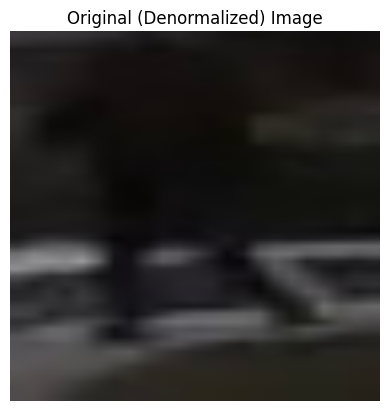

['../subset2\\images\\video_0015\\00062.png', '../subset2\\images\\video_0015\\00077.png', '../subset2\\images\\video_0015\\00092.png', '../subset2\\images\\video_0015\\00107.png', '../subset2\\images\\video_0015\\00122.png', '../subset2\\images\\video_0015\\00137.png', '../subset2\\images\\video_0015\\00152.png', '../subset2\\images\\video_0015\\00167.png', '../subset2\\images\\video_0015\\00182.png', '../subset2\\images\\video_0015\\00197.png', '../subset2\\images\\video_0015\\00212.png', '../subset2\\images\\video_0015\\00227.png', '../subset2\\images\\video_0015\\00242.png', '../subset2\\images\\video_0015\\00257.png', '../subset2\\images\\video_0015\\00272.png', '../subset2\\images\\video_0015\\00287.png', '../subset2\\images\\video_0015\\00302.png', '../subset2\\images\\video_0015\\00317.png']


In [ ]:
print((all_images_test[0][0].shape))
plt.imshow(all_images_test[0][0])
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()
print((seq_test['image'][0]))

# POSE KEYPOINTS: 

In [ ]:
def extract_pose_sequence(frames, body_model):
    """funzione che prende in input i frames e il modello di openpose e restituisce una lista di tensori di pose 
    per ciascuna persona nel tempo, se non prende nessuna posa mette un placeholder"""
    #print(frames)
    pose_sequences = []  # Lista di pose per ciascuna persona nel tempo
    pose_placeholder = torch.zeros((36,), dtype=torch.float32)
    for frame in frames:
        candidate, subset = body_model(frame)

        # block to visualize the poses on the images by printing both
        # canvas = copy.deepcopy(frame)
        # canvas = util.draw_bodypose(canvas, candidate, subset)
        # plt.imshow(canvas[:, :, [2, 1, 0]])  # OpenCV usa BGR, matplotlib usa RGB
        # plt.axis('off')
        # plt.show()

        frame_poses = []
        for person in subset:
            if person[-1] >= 4:  # Almeno 4 punti chiave rilevati
                pose = []
                for i in range(18):
                    if person[i] != -1:
                        x, y = candidate[int(person[i])][:2]
                    else:
                        x, y = -1, -1  # Punti chiave mancanti
                    pose.extend([x, y])
                frame_poses.append(pose)
        if not frame_poses:
            frame_poses = [pose_placeholder.tolist()]
        pose_sequences.append(frame_poses)

    # Trasponi la lista di liste per ottenere le sequenze temporali per ciascuna persona
    person_pose_sequences = list(map(list, zip(*pose_sequences)))
    person_pose_sequences = [torch.tensor(person_poses, dtype=torch.float32) for person_poses in person_pose_sequences]
    return person_pose_sequences

In [ ]:

if RUN:
    body_model = Body(POSE_PATH)

    # Caricamento dei frame e estrazione delle pose
    all_poses = []
    all_poses_test = []
    # print(len(all_images))
    # print(len(all_images[0]))
    # print(len(all_images[0][0]))
    # print(all_images[0][0].shape)
    #itera tra i video e prendi i frames
    for pics in tqdm(all_images, desc="Extracting poses from image sequences"):
        #print(len(pics))
        pose_sequences = extract_pose_sequence(pics, body_model)
        all_poses.append(pose_sequences)
        #print(pose_sequences.shape)
    # Aggiungi le pose estratte alla sequenza di allenamento
    seq_train['poses'] = all_poses

    for pics in tqdm(all_images_test, desc="Extracting poses from image sequences of test set"):
        pose_sequences = extract_pose_sequence(pics, body_model)
        all_poses_test.append(pose_sequences)
    # Aggiungi le pose estratte alla sequenza di allenamento
    seq_test['poses'] = all_poses_test
    del body_model
    torch.cuda.empty_cache()
    # Apri il file in modalità scrittura binaria e salva il dizionario

    with open(POSE_CMD, 'wb') as f:
        pickle.dump(seq_train['poses'], f)
    with open(POSE_CMD_TEST, 'wb') as f:
        pickle.dump(seq_test['poses'], f)
else:
    #recover data:
    with open(POSE_CMD, 'rb') as f:
        seq_train['poses'] = pickle.load(f)
    with open(POSE_CMD_TEST, 'rb') as f:
        seq_test['poses'] = pickle.load(f)
    # Verifica che i risultati siano stati caricati correttamente
    #print(seq_train['masks'])

In [ ]:
print((seq_train['poses']))
print((seq_test['poses']))


[[tensor([[ -1.,  -1., 141.,  40., 156.,  50., 198., 129.,  -1.,  -1., 129.,  27.,
          -1.,  -1.,  -1.,  -1.,  47.,  87.,  75., 203.,  -1.,  -1.,  24.,  68.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 186.,  38.,  -1.,  -1.],
        [ -1.,  -1., 133.,  38., 147.,  48., 189., 126.,  -1.,  -1., 121.,  27.,
          -1.,  -1.,  -1.,  -1.,  51.,  86., 102., 134.,  -1.,  -1.,  28.,  69.,
          44., 189.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 178.,  38.,  -1.,  -1.],
        [ -1.,  -1., 140.,  41., 157.,  46., 174.,  95.,  -1.,  -1., 127.,  34.,
          -1.,  -1.,  -1.,  -1.,  53., 135.,  -1.,  -1.,  -1.,  -1.,  14., 100.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 174.,  30.,  -1.,  -1.],
        [ -1.,  -1.,  86.,  48., 129.,  46., 193.,  74.,  -1.,  -1.,  42.,  50.,
           0.,  80.,  -1.,  -1., 110., 154.,  -1.,  -1.,  -1.,  -1.,  41., 148.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1., 1

# MODEL:

In [ ]:
class VisionBranchLocal(torch.nn.Module):
    """definizione del modello per il local context, prende in input le immagini croppate e restituisce un tensore,
    le immagini croppate vengono fatte passare dentro una VGG16, una GRU e un attention block"""

    def __init__(self, vgg16):
        super(VisionBranchLocal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)    # Fully connected layer
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Sigmoid()

    def forward(self, cropped_images):
        seq_len, c, h, w = cropped_images.size()
        
        # Estrai feature dalle immagini con VGG16
        vgg_features = []
        for i in range(seq_len):            

            img = cropped_images[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        gru_out, _ = self.gru(vgg_features)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        
       # print("SIZE vgg features:",vgg_features.shape)
       # print("SIZE context v local context:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [ ]:
class VisionBranchGlobal(torch.nn.Module):
    """definizione del modello per il global context, prende in input le maskere semantiche e restituisce un tensore,
    le maskere semantiche vengono fatte passare dentro una VGG16, una GRU e un attention block"""

    def __init__(self, vgg16):
        super(VisionBranchGlobal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)    # Fully connected layer
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Sigmoid()

    def forward(self, masks):
        seq_len = masks.size()[0]
        #print("size forward:",seq_len)
        # Estrai feature dalle immagini con VGG16
        vgg_features = []
        for i in range(seq_len):            
            img = masks[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        gru_out, _ = self.gru(vgg_features)
        attn_scores = self.attn(gru_out)  # shape: (batch_size, seq_length, 1)
       # print("SIZE attention scores GLO:", attn_scores.shape)
        
        attn_weights = torch.softmax(attn_scores, dim=1)  # shape: (batch_size, seq_length, 1)
        #print("SIZE attention weights GLO:", attn_weights.shape)
        
        context_vector = torch.sum(attn_weights * gru_out, dim=1)  # shape: (batch_size, 256)
        #print("SIZE context vector GLO:", context_vector.shape)
        
        out = self.tanh((context_vector))
        return out


In [ ]:
class NVisionBranch(torch.nn.Module):
    """classe relativa al non-vision brach, prende in input le pose e le bbox in formato tensore, esse vengono fatte passare
    dentro una GRU e un attention block, l'ordine influenza la prestazioni"""
    
    def __init__(self):
        super(NVisionBranch, self).__init__()
        self.gru = torch.nn.GRU(input_size=36, hidden_size=256, num_layers=2, batch_first=True)
        self.gru2 = torch.nn.GRU(input_size=256+4, hidden_size=256, num_layers=2, batch_first=True)
        #self.fc = torch.nn.Linear(256, 2)  
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Sigmoid()

    def forward(self, poses,bbox):
        gru_out, _ = self.gru(poses)
        #print("SIZE outuyput gru posa:",gru_out.shape)
        #print("bbox:",bbox.shape)
        LP = torch.cat((gru_out,bbox),dim=-1)
        #print("SIZE outuyput gru posa + bbox:",LP.shape)
        gru_out, _ = self.gru2(LP)
       # print("SIZE output gru:",gru_out.shape)

        # Attention mechanism
        #features = torch.stack([gru_out[:,i,:] for i in range(gru_out.size(1))], dim=1)
        attn_scores = self.attn(gru_out)  # shape: (batch_size, seq_length, 1)
       # print("SIZE attention scores:", attn_scores.shape)
        
        attn_weights = torch.softmax(attn_scores, dim=1)  # shape: (batch_size, seq_length, 1)
        #print("SIZE attention weights:", attn_weights.shape)
        
        context_vector = torch.sum(attn_weights * gru_out, dim=1)  # shape: (batch_size, 256)
        #print("SIZE context vector:", context_vector.shape)
        
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh(context_vector)
        return out


In [ ]:
# class PedestrianIntentModel(torch.nn.Module):
#     """definizione del modello finale, prende in input gli output del vision brach e del non vision branch, viene fatta
#     una concatenazione che in seguito passa dentro un attention e un fully connected layer, l'output è la predizione,
#     (passa non passa)"""

#     def __init__(self, vision_branch_local,vision_branch_global,non_vision_branch):
#         super(PedestrianIntentModel, self).__init__()
#         self.vision_branch_local = vision_branch_local
#         self.vision_branch_global = vision_branch_global
#         self.non_vision_branch = non_vision_branch
#         self.attn = torch.nn.Linear(768, 768)  # Attention layer

#         self.fc1 = torch.nn.Linear(768, 256) # Output: crossing or not crossing
#         self.fc2 = torch.nn.Linear(256,1) # Output: crossing or not crossing

#         self.sigmoid = torch.nn.Sigmoid()
        
#     def forward(self, cropped_images, bboxes, masks, poses):
#         vision_out_local = self.vision_branch_local(cropped_images)
#         vision_out_global = self.vision_branch_global(masks)
#         non_vision_out = self.non_vision_branch(poses, bboxes)

#         vision_out = torch.cat((vision_out_local, vision_out_global), dim=-1)
#         final_fusion = torch.cat((vision_out, non_vision_out), dim=-1)

#         attn_scores = self.attn(final_fusion)
#         attn_weights = torch.softmax(attn_scores, dim=-1)
#         context_vector = torch.sum(attn_weights * final_fusion, dim=0)

#         logits = self.fc2(self.fc1(context_vector))
#         probs = self.sigmoid(logits)
#         return probs

#     def predict(self, cropped_images, bboxes, masks, poses, threshold=0.5):
#         """
#         Metodo per ottenere la predizione finale in termini di classe (0 o 1).
#         """
#         probs = self.forward(cropped_images, bboxes, masks, poses)
#         predictions = (probs >= threshold).float()
#         return predictions

In [ ]:
class PedestrianIntentModel(torch.nn.Module):
    """definizione del modello finale, prende in input gli output del vision brach e del non vision branch, viene fatta
    una concatenazione che in seguito passa dentro un attention e un fully connected layer, l'output è la predizione,
    (passa non passa)"""

    def __init__(self, vision_branch_local,vision_branch_global,non_vision_branch):
        super(PedestrianIntentModel, self).__init__()
        self.vision_branch_local = vision_branch_local
        self.vision_branch_global = vision_branch_global
        self.non_vision_branch = non_vision_branch
        self.attn = torch.nn.Linear(768, 768)  # Attention layer

        self.fc1 = torch.nn.Linear(768, 256) # Output: crossing or not crossing
        self.fc2 = torch.nn.Linear(256,2) # Output: crossing or not crossing

        self.softmax = torch.nn.Softmax()
        
    def forward(self, cropped_images, bboxes, masks, poses):
        vision_out_local = self.vision_branch_local(cropped_images)
        vision_out_global = self.vision_branch_global(masks)
        non_vision_out = self.non_vision_branch(poses, bboxes)

        vision_out = torch.cat((vision_out_local, vision_out_global), dim=-1)
        final_fusion = torch.cat((vision_out, non_vision_out), dim=-1)

        attn_scores = self.attn(final_fusion)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        context_vector = torch.sum(attn_weights * final_fusion, dim=0)

        out = (self.fc2(self.fc1(context_vector)))
        return out


In [ ]:
class VGG16_FeatureExtractor(torch.nn.Module):

    def __init__(self):
        super(VGG16_FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children())[:24]) # block4_pool è il 23° livello
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
# Carica il modello VGG19 pre-addestrato
vgg16 = models.vgg16(pretrained=True)

#cut the model at the 24th layer:
vgg16_fe = VGG16_FeatureExtractor()
vgg16_fe


# define the models of each branches
model_local = VisionBranchLocal(vgg16_fe).to(device)
model_global = VisionBranchGlobal(vgg16_fe).to(device)
model_non_vision = NVisionBranch().to(device)
model = PedestrianIntentModel(model_local,model_global,model_non_vision).to(device)
#model


c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jacop\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# DATASET & DATALOADER

In [ ]:
class JAADDataset(Dataset):
    """definizione della classe per il custom dataset, prende in input la seq_train, le immagini e le trasformazioni,
    restituisce il tensore delle immagini croppate, le bboxes, le maschere, le pose e la lables"""

    def __init__(self, seq_data, all_images, transform=None):
        self.seq_data = seq_data
        self.all_images = all_images
        self.transform = transform

    def __len__(self):
        return len(self.seq_data['image'])

    def __getitem__(self, idx):
        bbox_sequence = self.seq_data['bbox'][idx]
        masks = self.seq_data['masks'][idx]
        poses = self.seq_data['poses'][idx]
        all_images = self.all_images[idx]
        #open the images from the paths 
        #images = [Image.open(img_path).convert("RGB") for img_path in img_paths]

        #compute local context cropping images arroun the bboxes
        #cropped_images = [crop_image(img, bbox) for img, bbox in zip(images, bbox_sequence)]
        # #mask_paths = self.seq_data['masks'][idx]

        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]
        if self.transform:
            #images = [self.transform(img) for img in images]
            tensor_images = [self.transform(img) for img in all_images]
            #
            #masks = [mask.Resize(224, 224) for mask in masks]
        #print(seq_train['poses'][idx])
        #print(len(poses))
        bboxes = torch.tensor(self.seq_data['bbox'][idx], dtype=torch.float32)
        intents = torch.tensor(self.seq_data['intent'][idx], dtype=torch.float32)
        return  tensor_images, bboxes, masks, poses, intents

In [ ]:
train_dataset = JAADDataset(seq_train,all_images=all_images, transform=transform_lc)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = JAADDataset(seq_test,all_images=all_images_test, transform=transform_lc)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# TRAINING:

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:

# def evaluate_metrics(net, loader, device):
#     acc = torchmetrics.Accuracy(task="binary").to(device)
#     precision = torchmetrics.Precision(task="binary").to(device)
#     recall = torchmetrics.Recall(task="binary").to(device)
#     f1_score = torchmetrics.F1Score(task="binary").to(device)
    
#     net.eval()

#     for tensor_images, bboxes, masks, poses, intents in loader:
#         poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
#         poses = poses.squeeze(0)
#         poses = poses.view(len(tensor_images), -1, 36).permute(1, 0, 2)  # Reshape to (batch_size, numeroFrames, 36)
        
#         # Move tensors to device
#         tensor_images = torch.stack(tensor_images, dim=1).squeeze(0).permute(0, 1, 2, 3).to(device)  # Convert image list to tensor
#         masks = torch.stack(masks, dim=1).squeeze(0).float().to(device)  # Convert mask list to tensor
#         bboxes = bboxes.to(device)
#         poses = poses.to(device)
#         if intents[0][0].item() == 0:
#             intent = torch.Tensor([0.0, 1.0])
#         else:
#             intent= torch.Tensor([1.0,0.0])      
#         intents =intent.to(device)   
#         ypred = net(tensor_images, bboxes, masks, poses)
#         print("appnea uscito",ypred.shape,ypred)
#         ypred = torch.softmax(ypred,dim=-1)  # Apply softmax to the output
#         print("post softmax:",ypred.shape,ypred)
#         # Convert probabilities to class predictions using argmax
#         ypred_class = torch.argmax(ypred, dim=None)
#         print("after argmax",ypred_class,ypred_class.shape)

#         ypred_class = torch.Tensor([0]) if ypred[0] > ypred[1] else torch.Tensor([1])
#         print("after argmax",ypred_class,ypred_class.shape)
#         # Move tensors back to CPU and clean up memory
#         ints = torch.softmax(intents)
#         print("after argmaxxx",ints)

#         tensor_images.cpu()
#         masks.cpu()
#         bboxes.cpu()
#         poses.cpu()
#         del tensor_images, bboxes, masks, poses
#         torch.cuda.empty_cache()
#         indice = torch.nonzero(intents == 1).item()


#         # # Update metrics
#         # acc.update(ypred_class, intents)
#         # precision.update(ypred_class, intents)
#         # recall.update(ypred_class, intents)
#         # f1_score.update(ypred_class, intents)
        
#         intents.cpu()
#         del intents
#         torch.cuda.empty_cache()
    
#     metrics = {
#         'accuracy': acc.compute().item(),
#         'precision': precision.compute().item(),
#         'recall': recall.compute().item(),
#         'f1_score': f1_score.compute().item()
#     }
    
#     # Reset metrics for the next evaluation
#     acc.reset()
#     precision.reset()
#     recall.reset()
#     f1_score.reset()
    
#     return metrics

# # Example usage
# # metrics = evaluate_metrics(net, loader, device)
# # print(metrics)


In [ ]:

def evaluate_metrics(net, loader, device):
    acc = torchmetrics.Accuracy(task="binary").to(device)
    precision = torchmetrics.Precision(task="binary").to(device)
    recall = torchmetrics.Recall(task="binary").to(device)
    f1_score = torchmetrics.F1Score(task="binary").to(device)
    
    net.eval()
    total = 0
    correct =0 
    for tensor_images, bboxes, masks, poses, intents in loader:
        poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
        poses = poses.squeeze(0)
        poses = poses.view(len(tensor_images), -1, 36).permute(1, 0, 2)  # Reshape to (batch_size, numeroFrames, 36)
        
        # Move tensors to device
        tensor_images = torch.stack(tensor_images, dim=1).squeeze(0).permute(0, 1, 2, 3).to(device)  # Convert image list to tensor
        masks = torch.stack(masks, dim=1).squeeze(0).float().to(device)  # Convert mask list to tensor
        bboxes = bboxes.to(device)
        poses = poses.to(device)
        if intents[0][0].item() == 0:
            intent = torch.Tensor([0.0, 1.0])
        else:
            intent= torch.Tensor([1.0,0.0])      
        intents =intent.to(device)   
        ypred = net(tensor_images, bboxes, masks, poses)
        print("appnea uscito",ypred.shape,ypred)
        ypred = torch.softmax(ypred,dim=-1)  # Apply softmax to the output
        print("post softmax:",ypred.shape,ypred)
        # Convert probabilities to class predictions using argmax
        ypred_class = torch.argmax(ypred, dim=None)
        print("after argmax",ypred_class,ypred_class.shape)

        ypred_class = torch.Tensor([0]) if ypred[0] > ypred[1] else torch.Tensor([1])
        print("after argmax",ypred_class,ypred_class.shape)
        # Move tensors back to CPU and clean up memory
        ints = torch.softmax(intents)
        print("after argmaxxx",ints)

        tensor_images.cpu()
        masks.cpu()
        bboxes.cpu()
        poses.cpu()
        del tensor_images, bboxes, masks, poses
        torch.cuda.empty_cache()
        correct+=(ints ==ypred_class).sum().item()
        total+=1

        # # Update metrics
        # acc.update(ypred_class, intents)
        # precision.update(ypred_class, intents)
        # recall.update(ypred_class, intents)
        # f1_score.update(ypred_class, intents)
        
        intents.cpu()
        del intents
        torch.cuda.empty_cache()
    

    
    # Reset metrics for the next evaluation
    metrics = correct/total
    
    return metrics

# Example usage
# metrics = evaluate_metrics(net, loader, device)
# print(metrics)


In [ ]:

num_epochs = 10

# free the memory
torch.cuda.empty_cache()

# Placeholder tensor for empty poses
pose_placeholder = torch.zeros((36,), dtype=torch.float32) 

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()

    for tensor_images, bboxes, masks, poses, intents in tqdm(train_loader):
        #case when there are no poses in the frame 
        # if len(poses) == 0:
        #     print("Empty poses detected, adding placeholder tensor.")
        #     poses = [pose_placeholder for _ in range(len(tensor_images))]
        #     poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
        #     #poses = poses.squeeze(0)
        #     poses = poses.view(len(tensor_images), -1, 36).permute(1,0,2)  # Reshape to (batch_size, numeroFrames, 36)
        # else:
        #     #poses = [torch.tensor(p, dtype=torch.float32) for p in poses]
        #     poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
        #     poses = poses.squeeze(0)
        # poses = [pose_placeholder for _ in range(len(tensor_images))]
        # poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
        poses = torch.stack(poses, dim=0)  # Now the shape is (batch_size, 36)
        poses = poses.squeeze(0)
        #poses = poses.squeeze(0)
        poses = poses.view(len(tensor_images), -1, 36).permute(1,0,2)  # Reshape to (batch_size, numeroFrames, 36)
        #print("TRAINING:")
        #print("poses",len(poses))
        # Convert poses to tensor and reshape
        #print("poses shape:",poses.shape)   

        # Move tensors to device
        tensor_images = torch.stack(tensor_images, dim=1).squeeze(0).permute(0, 1, 2,3).to(device)  # Converte la lista di immagini in un tensor
        masks = torch.stack(masks,dim=1).squeeze(0).float().to(device)  # Converte la lista di maschere in un tensor
        bboxes = bboxes.to(device)
        poses = poses.to(device)
        #intents=torch.argmax(torch.Tensor(intents),axis=1)
        #print("prova", intents[0][0])
        if intents[0][0].item() == 0:
            intent = torch.Tensor([0.0, 1.0])
        else:
            intent= torch.Tensor([1.0,0.0]) 
        
        intents = intent.to(device)
        # print("ti",tensor_images.shape)
        # print("BBOX:", bboxes.shape)
        # print("MASKS:", masks.shape)
        # print("POSES:", poses.shape)
        # print("INTENTS:", intents.shape)

        optimizer.zero_grad()

        outputs = model(tensor_images, bboxes, masks, poses)
        tensor_images.cpu()
        #print("TRAIN out vs intents",outputs,intents)
        masks.cpu()
        bboxes.cpu()
        poses.cpu()
        # print(outputs)
        # print(intent)
        # print(intents)
        #outputs = torch.argmax((outputs))
        loss = criterion(outputs, intents.float())
        loss.backward()
        #for name, param in model.named_parameters():
            #if param.grad is not None:
                #print(f"Gradiente di {name}: {param.grad.norm()}")

        optimizer.step()
        del tensor_images, masks, bboxes, poses, intents, outputs
        torch.cuda.empty_cache()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    with torch.no_grad():
        print(f'Accuracy at epoch {epoch}: {evaluate_metrics(model, test_loader, device)}')
        



Epoch 1/10


100%|██████████| 60/60 [00:33<00:00,  1.79it/s]


Epoch [1/10], Loss: 0.6381
appnea uscito torch.Size([2]) tensor([-0.1106,  0.1182], device='cuda:0')
post softmax: torch.Size([2]) tensor([0.4431, 0.5569], device='cuda:0')
after argmax tensor(1, device='cuda:0') torch.Size([])
after argmax tensor([1.]) torch.Size([1])


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([1]) and torch.Size([2]).

# las

In [ ]:
print(seq_train['intent'])
print(seq_train['poses'])
print(len(seq_train['intent']))

In [ ]:
print(seq_test['intent'])
print(len(seq_test['intent']))

In [ ]:
print(seq_train['image'])

In [ ]:
del tensor_images, masks, bboxes, poses, intents
torch.cuda.empty_cache()
